# Bose-Hubbard model

This notebook builds a **Bose–Hubbard** Hamiltonian over a graph and minimizes its energy with a **photonic variational circuit** in Optyx. We’ll:
 
1) prepare a photonic ansatz,  
2) define creation/annihilation and number operators on a single photonic mode,  
3) assemble the Hamiltonian \(H\) from a NetworkX graph using *function syntax*, 
4) evaluate $E(\boldsymbol\theta)=\langle\psi|H|\psi\rangle$ and its gradients,  
5) run an optimiser with a decaying learning rate, and  
6) plot convergence

## Ansatz
Define the variational ansatz:

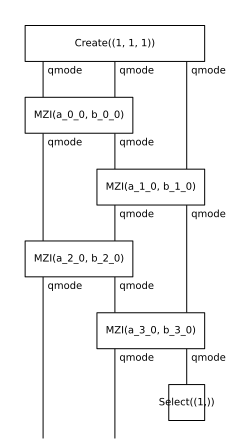

In [ ]:
from optyx import photonic

circuit = photonic.Create(1, 1, 1) >> photonic.ansatz(3, 4) >> photonic.Id(2) @ photonic.Select(1)
circuit.draw()

## The model

Define the creation/annihilation channels for a single photonic mode; we’ll reuse these to place operators on specific lattice sites.


In [ ]:
from optyx import Channel
from optyx.core.diagram import mode
from optyx.core.zw import W, Create, Select

creation_op = Channel(
    "a†",
    Create(1) @ mode >> W(2).dagger()
)

annihilation_op = Channel(
    "a",
    W(2) >> Select(1) @ mode
)

We’ll construct the Bose–Hubbard Hamiltonian $H(t,U,\mu)$ on an arbitrary graph using function syntax so each term edits only its intended wire(s).


![Bose Hubbard model](./bose_hubbard.png "Bose Hubbard model")

In [ ]:
import networkx as nx
from optyx import Diagram, qmode
from optyx.photonic import NumOp, Scalar

def bose_hubbard_from_graph(
        graph: nx.Graph,
        t: float,
        mu: float,
        U: float
):
    nodes = sorted(graph.nodes())
    idx = {u: i for i, u in enumerate(nodes)}
    N = len(nodes)

    H = None

    # hopping: -t (a_i^dagger a_j + a_j^dagger a_i)
    for u, v in graph.edges():
        i, j = idx[u], idx[v]

        @Diagram.from_callable(dom=qmode**N, cod=qmode**N)
        def hop_ij(*in_wires):
            # a_i^dagger a_j
            out = list(in_wires)
            out[i] = creation_op(out[i])
            out[j] = annihilation_op(out[j])
            Scalar(-t)()
            return tuple(out)

        @Diagram.from_callable(dom=qmode**N, cod=qmode**N)
        def hop_ji(*in_wires):
            # a_j^dagger a_i
            out = list(in_wires)
            out[j] = creation_op(out[j])
            out[i] = annihilation_op(out[i])
            Scalar(-t)()
            return tuple(out)

        H = (hop_ij + hop_ji) if H is None else (H + hop_ij + hop_ji)

    # onsite interaction: (U/2) a_i^dagger a_i^dagger a_i a_i
    for u in nodes:
        i = idx[u]

        @Diagram.from_callable(dom=qmode**N, cod=qmode**N)
        def quartic_i(*in_wires, i=i):
            out = list(in_wires)
            w = out[i]
            w = creation_op(w)
            w = creation_op(w)
            w = annihilation_op(w)
            w = annihilation_op(w)
            out[i] = w
            Scalar(U/2)()
            return tuple(out)

        H = quartic_i if H is None else (H + quartic_i)

    # -mu n_i
    for u in nodes:
        i = idx[u]

        @Diagram.from_callable(dom=qmode**N, cod=qmode**N)
        def n_i(*in_wires, i=i):
            out = list(in_wires)
            out[i] = NumOp()(out[i])
            Scalar(-mu)()
            return tuple(out)

        H = n_i if H is None else (H + n_i)

    return H


Assemble hopping, on-site interaction, and chemical-potential terms into one Diagram representing the full Hamiltonian on $qmode^{\otimes N}$. Start with a 2-site chain and some parameters:


In [5]:
import networkx as nx

graph = nx.path_graph(2) # 2 sites

t, U, mu = 0.10, 4.0, 2.0

hamiltonian = bose_hubbard_from_graph(graph, t, mu, U)

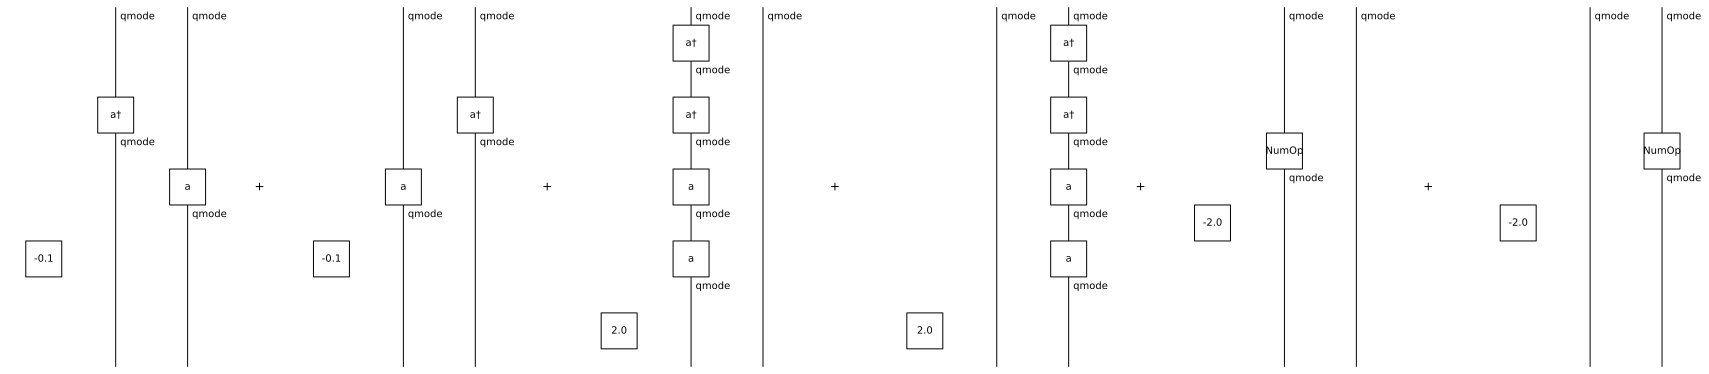

In [6]:
hamiltonian.draw()

In [7]:
expectation = circuit >> hamiltonian >> circuit.dagger()

## Optimisation

In [8]:
from optyx.core.backends import PermanentBackend


def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-8, x
        return x.real
    return x

free_syms = list(expectation.free_symbols)

f_exp = lambda xs: to_float(
    expectation.lambdify(*free_syms)(*xs)
    .eval(PermanentBackend())
    .tensor
    .array
)

def d_f_exp(xs):
    return [
        expectation.grad(s).lambdify(*free_syms)(*xs)
        .eval(PermanentBackend())
        .tensor
        .array
        for s in free_syms
    ]

Run a short gradient-descent loop with a decaying learning rate to drive the energy down.

In [38]:
from tqdm import tqdm

xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0
    lr = 5
    steps = 10
    for _ in tqdm(range(steps)):
        fx = f_exp(x)
        dfx = d_f_exp(x)

        xs.append(x[::])
        fxs.append(fx)
        dfxs.append(dfx)
        for i, dfxx in enumerate(dfx):
            x[i] = to_float(x[i] - lr * dfxx)

        lr *= 0.2*(i**(1/6)) # make lr smaller with each step

    xs.append(x[::])
    fxs.append(f_exp(x))
    dfxs.append(d_f_exp(x))

In [39]:
optimize([2]*len(free_syms))

100%|██████████| 10/10 [05:31<00:00, 33.16s/it]


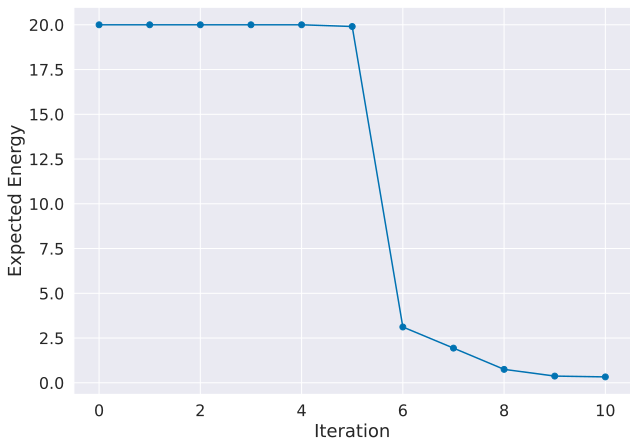

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, axs = plt.subplots(1, 1, figsize=(10, 7))

axs.plot(range(len(xs)), fxs, c="#0072B2", marker='o')
axs.set_xlabel('Iteration', fontsize=18)
axs.set_ylabel('Expected Energy', fontsize=18)
axs.grid(True)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.tick_params(axis='both', which='minor', labelsize=16)
plt.show()